# Using Pokemon statistics such as HP and Attack to predict evolutionary stage

DSCI Final Project
By Brady Bracken, Ally Davies, Eric Zhang, Louis Ryu

## Section 1 - Introduction: 
Pokemon is an international video game franchise that has been popular for many years. The creatures found in the Pokemon games, called Pokemon, each have their own unique properties. There are 1032 unique Pokemon across all current games. They have basic definitions such as their Type, stats (HP, Attack, Special Attack, Defense, Special Defense, Speed), and whether or not they are a final evolution. 

**Important Note:** There are some Pokemon that do not evolve, either because they are a Legendary Pokemon (ex: Lugia, Mewtwo), or because they simply don't have one (ex: Plusle, Shuckle).

We want to use classification to predict whether a pokemon is a final evolution or not using HP and Attack.

### Predictive Question: 
**How accurately does using a Pokemon's HP and Attack predict whether a Pokemon is the Final Evolution or not?**

To answer this question, we used a dataset on Kaggle which includes the stats and attributes of all 1032 Pokemon across all of the games. 

## Section 2: Methods and Results


In [47]:
### Run this cell before continuing. 
library(tidyverse)
library(repr)
library(tidymodels)
options(repr.matrix.max.rows = 6)

### Column Descriptions:

Below, we have read our Pokemon dataset (Source: https://www.kaggle.com/datasets/maca11/all-pokemon-dataset/data) into R, selecting only the columns we deem important. 

Those being,

- Name: Name of the Pokemon
- Type 1: The Pokemon's Primary type (we won't include secondary types in this)
- HP: The Pokemon's Base HP (Hit Points)
- Att: The Pokemon's Base Attack
- Def: The Pokemon's base defense
- Spa: The Pokemon's Base special attack
- Spd: The Pokemon's Base special defense
- Spe: The Pokemon's Base speed
- BST: The Total of the above 6 values, or Base Stat Total
- Mean: The average of all Base Stats
- Standard Deviation: Standard deviation of all base stats
- Generation: Generation it was introduced
- Final Evolution: 1 = Pokemon is a final evolution
                 0 = Pokemon is not a final Evolution
- Catch Rate: The catch rate, the higher the number, the harder it is to catch with a Poke Ball.
- Legendary: 1 = Pokemon is a Legendary
           0 = Pokemon is not a Legendary
- Mega Evolution: 1 = Pokemon is a Mega Evolution
                0 = Pokemon is not a Mega Evolution
- Height: The Pokemon's height
- Weight: The Pokemon's weight
- BMI: The Pokemon's BMI

In [48]:
## Run this cell first to download the database that we are interested in.
url <- 'https://raw.githubusercontent.com/bradyb2005/dsci-100-group-6/main/data/All_Pokemon.csv'
download.file(url, destfile = "data/All_Pokemon.csv")

In [50]:
## Run this cell to view the data, using only the variables listed above.
## We may not use all of this data, however we have listed all variables that may be useful.
## Table is ordered by the Pokemon's order of appearance (eg. Pokedex number)
pokemon_data <- read_csv("data/All_Pokemon.csv")
pokemon_data_selected <- select(pokemon_data, Name, `Type 1`, HP, Att, Def, Spa, Spd, Spe, BST, Mean,  `Standard Deviation`,
                                Generation, `Final Evolution`,  `Catch Rate`, Legendary, `Mega Evolution`, Height, Weight, BMI)
pokemon_data_selected

Rows: 1032 Columns: 44
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (5): Name, Type 1, Type 2, Abilities, Experience type
dbl (39): Number, HP, Att, Def, Spa, Spd, Spe, BST, Mean, Standard Deviation...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


Name,Type 1,HP,Att,Def,Spa,Spd,Spe,BST,Mean,Standard Deviation,Generation,Final Evolution,Catch Rate,Legendary,Mega Evolution,Height,Weight,BMI
<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Bulbasaur,Grass,45,49,49,65,65,45,318,53.0,8.640988,1,0,45,0,0,0.7,6.9,14.1
Ivysaur,Grass,60,62,63,80,80,60,405,67.5,8.902247,1,0,45,0,0,1.0,13.0,13.0
Venusaur,Grass,80,82,83,100,100,80,525,87.5,8.902247,1,1,45,0,0,2.0,100.0,25.0
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
Calyrex,Psychic,100,80,80,80,80,80,500,83.33333,7.45356,8,1,3,1,0,1.1,7.7,6.4
Calyrex Ice Rider,Psychic,100,165,150,85,130,50,680,113.33333,39.33475,8,1,3,1,0,2.4,809.1,140.5
Calyrex Shadow Rider,Psychic,100,85,80,165,100,150,680,113.33333,32.36081,8,1,3,1,0,2.4,53.6,9.3


### Selecting our relevant columns:

Below, we selected the 'Name' 'Type 1' 'HP' 'Attack' and 'Final Evolution' columns since we are focusing on them. After that we scale and center 'HP' and 'Attack' variables of the pokemon dataset and save them as columns in our data table.

In [51]:
## When running this cell, we view the columns that we will be using for this report. 
## We also scale the HP and Attack variables.
question_data <- select(pokemon_data, Name, `Type 1`, HP, Att, `Final Evolution`) |> 
                mutate(`Final Evolution` = `Final Evolution` == 1) |>
                mutate(scaled_HP = scale(HP, center = TRUE),
                       scaled_Att = scale(Att, center = TRUE))
question_data

Name,Type 1,HP,Att,Final Evolution,scaled_HP,scaled_Att
<chr>,<chr>,<dbl>,<dbl>,<lgl>,"<dbl[,1]>","<dbl[,1]>"
Bulbasaur,Grass,45,49,FALSE,-0.9510046,-0.96877268
Ivysaur,Grass,60,62,FALSE,-0.3782485,-0.56929352
Venusaur,Grass,80,82,TRUE,0.3854264,0.04528979
⋮,⋮,⋮,⋮,⋮,⋮,⋮
Calyrex,Psychic,100,80,TRUE,1.149101,-0.01616854
Calyrex Ice Rider,Psychic,100,165,TRUE,1.149101,2.59581053
Calyrex Shadow Rider,Psychic,100,85,TRUE,1.149101,0.13747728


### Methods:
We plan to use classification to predict whether a Pokemon is a final evolution or not using k-nearest-neighbors. We will use Scaled_HP and Scaled_Attack as our predictive variables.

One way we could visualize our results is very similar to the scatter plot we showed above. We create a plot chart, and we use the k-nearest-neighbors method to predict the outcome we want to know, and we compare our observations of the graph with the output of the k-nearest-neighbors method to get the conclusion of our observations.

We will visualize our results using a scatter plot, with our X value being HP and Y value being Attack.

In [46]:
# Don't remove this
set.seed(20)

# Randomly take 75% of the data in the training set. 

pokemon_split <- initial_split(question_data, prop = 0.75, strata = `Final Evolution`)  
pokemon_train <- training(pokemon_split)   
pokemon_test <- testing(pokemon_split)

pokemon_train
pokemon_test

Name,Type 1,HP,Att,Final Evolution,scaled_HP,scaled_Att
<chr>,<chr>,<dbl>,<dbl>,<lgl>,"<dbl[,1]>","<dbl[,1]>"
Bulbasaur,Grass,45,49,FALSE,-0.9510046,-0.9687727
Ivysaur,Grass,60,62,FALSE,-0.3782485,-0.5692935
Charmander,Fire,39,52,FALSE,-1.1801071,-0.8765852
⋮,⋮,⋮,⋮,⋮,⋮,⋮
Spectrier,Ghost,100,65,TRUE,1.149101,-0.47710603
Calyrex,Psychic,100,80,TRUE,1.149101,-0.01616854
Calyrex Shadow Rider,Psychic,100,85,TRUE,1.149101,0.13747728


Name,Type 1,HP,Att,Final Evolution,scaled_HP,scaled_Att
<chr>,<chr>,<dbl>,<dbl>,<lgl>,"<dbl[,1]>","<dbl[,1]>"
Charmeleon,Fire,58,64,FALSE,-0.4546160,-0.5078352
Charizard,Fire,78,84,TRUE,0.3090589,0.1067481
Pidgey,Normal,40,45,FALSE,-1.1419233,-1.0916893
⋮,⋮,⋮,⋮,⋮,⋮,⋮
Zacian,Fairy,92,130,TRUE,0.8436313,1.5202897
Regidrago,Dragon,200,100,TRUE,4.9674757,0.5984148
Calyrex Ice Rider,Psychic,100,165,TRUE,1.1491013,2.5958105


### Preliminary Analysis:

We are going to test balance by computing the percentage of Final Evolution Pokemon compared to the total Pokemon.

In [58]:
pokemon_evo_notfinal <- question_data |>
    filter(`Final Evolution` == FALSE) |>
    nrow()

pokemon_evo_final <- question_data |>
    filter(`Final Evolution` == TRUE) |>
    nrow()

percent_notfinal <- (pokemon_evo_notfinal/1032)*100

percent_final <- (pokemon_evo_final/1032)*100

print("Number of Pokemon that are NOT a Final Evolution:")
pokemon_evo_notfinal
print("Perecntage of Pokemon that are NOT a Final Evolution:")
percent_notfinal
print("Number of Pokemon that are a Final Evolution:")
pokemon_evo_final
print("Perecntage of Pokemon that are a Final Evolution:")
percent_final

[1] "Number of Pokemon that are NOT a Final Evolution:"


[1] 449

[1] "Perecntage of Pokemon that are NOT a Final Evolution:"


[1] 43.50775

[1] "Number of Pokemon that are a Final Evolution:"


[1] 583

[1] "Perecntage of Pokemon that are a Final Evolution:"


[1] 56.49225

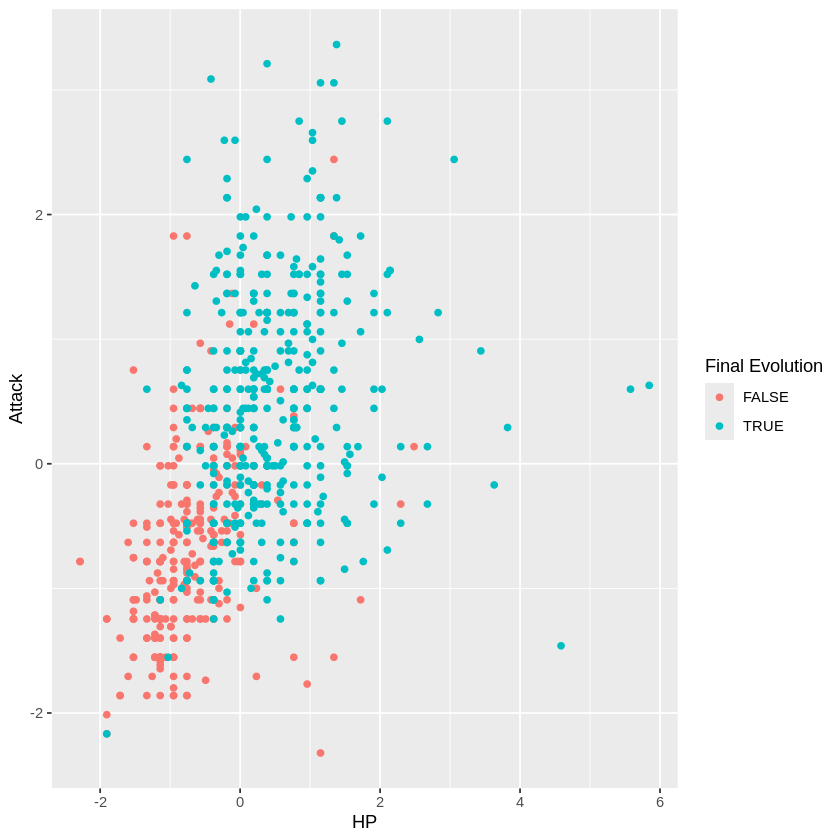

In [61]:
## this scatterplot will plot a Pokemon's HP on the x-axis and the Attack on the y-axis, 
## coloring Final Evolutions as blue and not Final Evolutions as Red.
capture_data <- pokemon_train |>
    ggplot(aes(x = scaled_HP, y = scaled_Att, color = `Final Evolution`)) +
    geom_point() +
    labs(x= "HP", y = "Attack")
capture_data

## Section 3: Outcomes and Significance

(insert what do you expect to find)
We expect to find the relationship between BST,Attack, and final evolution status. This will show if there is a trend for final evolutions to have different BST and Attack scores, and how they could be used to determine a final evolution status of an unknown pokemon.


(insert what impact could such findings have)
This would allow pokemon to be identified and classified with limited information, and also give game devolopers an easier time creating pokemon as they can come up with stats and be told the final evolution status.

(insert what future questions this could lead to)
This data analysis could lead to future questions such as:

What does the final evolution status look like divided by pokemon type?

Do different types have different BST and attack scores that could be used to determine not only evolution status, but also tye?

What components of BST have the biggest impact on the score and final evolution status?
